In [ ]:
import pickle
import gzip
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/mnielsen/neural-networks-and-deep-learning.git

Cloning into 'neural-networks-and-deep-learning'...
remote: Enumerating objects: 1172, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1172 (delta 4), reused 0 (delta 0), pack-reused 1166 (from 3)
Receiving objects: 100% (1172/1172), 20.43 MiB | 23.50 MiB/s, done.
^C


In [ ]:
def load_data(dir):
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    #f = gzip.open('./neural-networks-and-deep-learning/data/mnist.pkl.gz', 'rb')
    #training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    #f.close()
    #return (training_data, validation_data, test_data)
    training_data = []
    for i in range(6):
        f_training = gzip.open(dir + '/training' + str(i+1) + '.pkl.gz', 'rb')
        data = pickle.load(f_training, encoding='latin1')
        f_training.close()
        if (i == 0):
          training_data = data
        else:
          training_data = [l1 + l2 for l1, l2 in zip(training_data, data)]
    f_test = gzip.open(dir + '/testing.pkl.gz', 'rb')
    test_data = pickle.load(f_test, encoding='latin1')
    f_test.close()
    return (training_data, None, test_data)

In [ ]:
def load_data_wrapper(dir):
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data(dir)
    training_inputs = [x.reshape(14400, 1) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    #training_data = zip(training_inputs, training_results)
    training_data = [(x, y) for x, y in zip(training_inputs, training_results)]
    #validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    #validation_data = zip(validation_inputs, va_d[1])
    #validation_data = [(x, y) for x, y in zip(validation_inputs, va_d[1])]
    test_inputs = [x.reshape(14400, 1) for x in te_d[0]]
    #test_data = zip(test_inputs, te_d[1])
    test_data = [(x, y) for x, y in zip(test_inputs, te_d[1])]
    #return (training_data, validation_data, test_data)
    return (training_data, None, test_data)

In [ ]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    #e = np.zeros((10, 1))
    #e[j] = 1.0
    #return e
    return [j]

In [ ]:
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            if test_data:
                print("Epoch {0}:".format(j))
                print("\t test accuracy: {0}".format(self.evaluate(test_data) / n_test))
                print("\t training accuracy: {0}".format(self.evaluate(training_data) / n))
                print("\t test MSE: {0}".format(self.calculate_MSE(test_data)))
                print("\t training MSE: {0}".format(self.calculate_MSE(training_data)))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        #test_results = [(np.argmax(self.feedforward(x)), y)
        #                for (x, y) in test_data]
        test_results = [(self.feedforward(x)[0][0], y) for (x, y) in test_data]
        return sum(np.round(x) == y for (x, y) in test_results)

    def calculate_MSE(self, data):
        """Return the mean squared error for the data"""
        test_results = [(self.feedforward(x)[0][0], y) for (x, y) in data]
        return sum((x - y)**2 for (x, y) in test_results) / len(data)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:122: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1404647474.py:122: SyntaxWarning: invalid escape sequence '\p'
  """Return the vector of partial derivatives \partial C_x /


In [ ]:
def save_model(net, filename):
  with gzip.open(filename, 'wb') as f:
    pickle.dump(net, f)

def load_model(filename):
  with gzip.open(filename, 'rb') as f:
    return pickle.load(f)

In [ ]:
dir = '/content/drive/MyDrive/honors_thesis_data/is_planar_random_layout'

In [ ]:
training_data, validation_data, test_data = load_data_wrapper(dir)

In [ ]:
net = Network([14400, 100, 1])

In [ ]:
net.SGD(training_data, 20, 20, 0.1, test_data=test_data)

Epoch 0:
	 test accuracy: 0.6926
	 training accuracy: [0.70246667]
	 test MSE: 0.19728990186283207
	 training MSE: [0.19392702]
Epoch 1:
	 test accuracy: 0.7123
	 training accuracy: [0.72046667]
	 test MSE: 0.18728242611151633
	 training MSE: [0.18499205]
Epoch 2:
	 test accuracy: 0.7208
	 training accuracy: [0.73113333]
	 test MSE: 0.18270245769591203
	 training MSE: [0.17916561]
Epoch 3:
	 test accuracy: 0.7343
	 training accuracy: [0.74101667]
	 test MSE: 0.17486140647742163
	 training MSE: [0.17273856]
Epoch 4:
	 test accuracy: 0.7406
	 training accuracy: [0.74715]
	 test MSE: 0.17286655141522542
	 training MSE: [0.16957604]
Epoch 5:
	 test accuracy: 0.744
	 training accuracy: [0.75173333]
	 test MSE: 0.17014214577427236
	 training MSE: [0.16678106]
Epoch 6:
	 test accuracy: 0.7496
	 training accuracy: [0.75233333]
	 test MSE: 0.16629766107789143
	 training MSE: [0.16438603]
Epoch 7:
	 test accuracy: 0.7487
	 training accuracy: [0.75718333]
	 test MSE: 0.16594093800654036
	 trainin

In [ ]:
save_model(net, dir + '/model.pkl.gz')

In [ ]:
net = load_model(dir + '/model.pkl.gz')

In [ ]:
print("\t test accuracy: {0}".format(net.evaluate(test_data) / len(test_data)))
print("\t training accuracy: {0}".format(net.evaluate(training_data) / len(training_data)))
print("\t test MSE: {0}".format(net.calculate_MSE(test_data)))
print("\t training MSE: {0}".format(net.calculate_MSE(training_data)))

	 test accuracy: 0.9966


KeyboardInterrupt: 

In [ ]:
correct = []
wrong = []

c = 0
w = 0
shuffled_test_data = random.sample(test_data, len(test_data))
for (x, y) in shuffled_test_data:
  res = net.feedforward(x)[0][0]
  if round(res) == y and c < 5:
    print(res, y, "correct")
    c += 1
    correct.append(x)
  elif round(res) != y and w < 5:
    print(res, y, "wrong")
    w += 1
    wrong.append(x)
  if c >= 5 and w >= 5:
    break


0.009743226028779717 0 correct
0.12852598358736764 0 correct
0.9814021848211644 1 correct
0.3417469954791626 0 correct
0.6599704182833015 1 correct
0.222771191548814 1 wrong
0.3296376186206205 1 wrong
0.41041255114356795 1 wrong
0.07335752050144223 1 wrong
0.6280343218836729 0 wrong


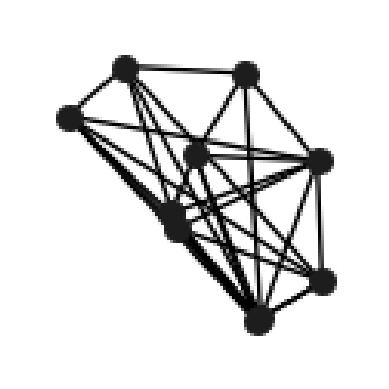

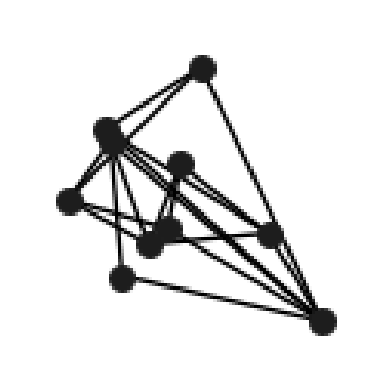

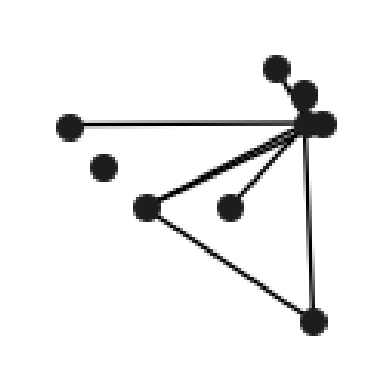

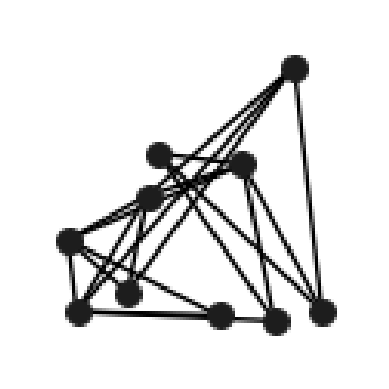

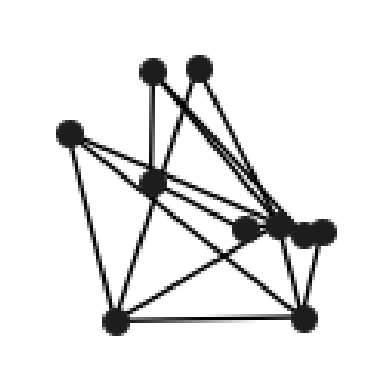

In [ ]:
for x in correct:
  plt.imshow(x.reshape(120, 120), cmap='gray')
  plt.axis('off')
  plt.show()

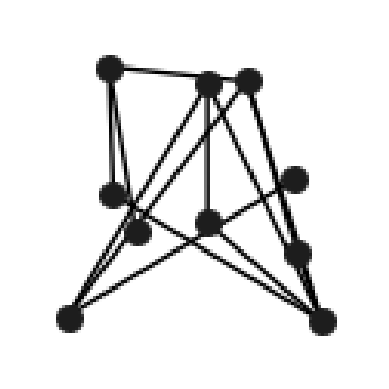

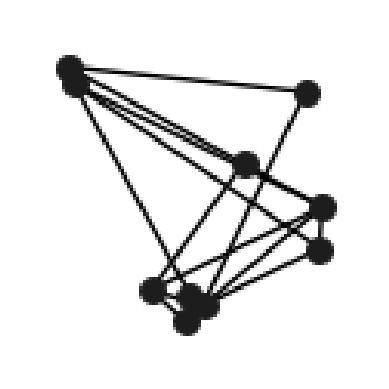

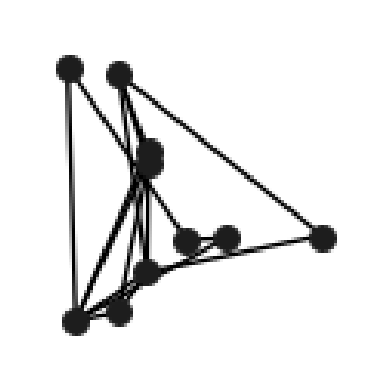

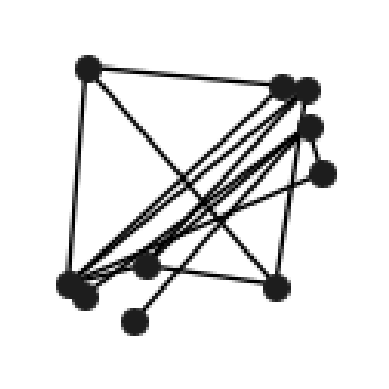

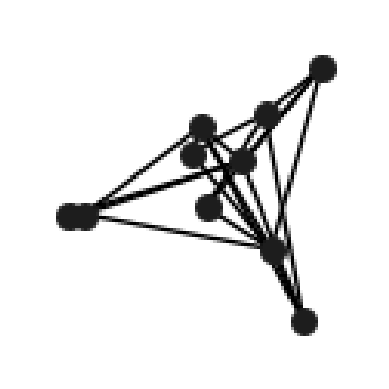

In [ ]:
for x in wrong:
  plt.imshow(x.reshape(120, 120), cmap='gray')
  plt.axis('off')
  plt.show()